In [58]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler

sns.set(style='whitegrid')

# Business Context / Motivation
Predicting product rating categories (Low, Medium, High) helps Sephora understand which products are performing well and which may need improvement.  
This can inform marketing strategies, inventory management, and product recommendations for customers.


In [59]:
# Cell 2: Load Data
df = pd.read_csv('sephora_website_dataset.csv')
print(df.shape)
display(df.head())
display(df.info())

(9168, 21)


,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,True,online only,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,True,online only,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26,2600,180.0,180.0,...,True,online only,- 1oz/30mL Eau de Toilette - 2.5 oz/ 74 mL E...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23,2900,120.0,120.0,...,True,online only,- 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2,943,72.0,80.0,...,True,online only,no options,The Colonia Miniature Set comes in an iconic A...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9168 entries, 0 to 9167
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9168 non-null   int64  
 1   brand                   9168 non-null   object 
 2   category                9168 non-null   object 
 3   name                    9168 non-null   object 
 4   size                    9168 non-null   object 
 5   rating                  9168 non-null   float64
 6   number_of_reviews       9168 non-null   int64  
 7   love                    9168 non-null   int64  
 8   price                   9168 non-null   float64
 9   value_price             9168 non-null   float64
 10  URL                     9168 non-null   object 
 11  MarketingFlags          9168 non-null   bool   
 12  MarketingFlags_content  9168 non-null   object 
 13  options                 9168 non-null   object 
 14  details                 9168 non-null   

None

In [60]:
# Cell 3: Categorize Ratings
bins = [0, 3.5, 4.5, 5]
labels = ['Low', 'Medium', 'High']
df['rating_category'] = pd.cut(df['rating'], bins=bins, labels=labels, include_lowest=True)
print(df['rating_category'].value_counts())

rating_category
Medium    6380
Low       1916
High       872
Name: count, dtype: int64


In [61]:
# Cell 4: Prepare Features and Target
X = df.drop(columns=['rating_category', 'rating', 'id', 'name', 'URL', 'details', 'how_to_use', 'ingredients', 'options'])
y = df['rating_category']

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'bool']).columns

imputer_num = SimpleImputer(strategy='median')
X[num_cols] = imputer_num.fit_transform(X[num_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
X[cat_cols] = imputer_cat.fit_transform(X[cat_cols])

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [62]:
# Cell 5: Train/Test Split and Oversampling
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

# Model Hyperparameters
- Logistic Regression: max_iter=2000 to ensure convergence on scaled data.
- Random Forest: n_estimators=100 (default, provides good performance with moderate computation time).
- XGBoost: eval_metric='mlogloss', default hyperparameters, chosen for multi-class classification.
These settings balance model performance and computational efficiency for this dataset.


In [63]:
# Cell 6: Define Models and Train (Updated for XGBoost 1.7+)
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42)  # removed use_label_encoder
}

for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_bal_scaled, y_train_bal)
    else:
        model.fit(X_train_bal, y_train_bal)


In [64]:
# Cell 7: Model Evaluation
for name, model in models.items():
    if name == 'Logistic Regression':
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=le_target.classes_))


=== Logistic Regression ===
              precision    recall  f1-score   support

        High       0.19      0.68      0.30       175
         Low       0.23      0.26      0.24       383
      Medium       0.85      0.52      0.64      1276

    accuracy                           0.48      1834
   macro avg       0.42      0.48      0.39      1834
weighted avg       0.66      0.48      0.53      1834


=== Random Forest ===
              precision    recall  f1-score   support

        High       0.45      0.42      0.44       175
         Low       0.54      0.37      0.44       383
      Medium       0.80      0.88      0.83      1276

    accuracy                           0.73      1834
   macro avg       0.60      0.56      0.57      1834
weighted avg       0.71      0.73      0.71      1834


=== XGBoost ===
              precision    recall  f1-score   support

        High       0.39      0.50      0.44       175
         Low       0.52      0.49      0.50       383
      

/var/folders/jy/khj1mqxd76g95bsx5f7vlnqm0000gn/T/ipykernel_34830/2142942988.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




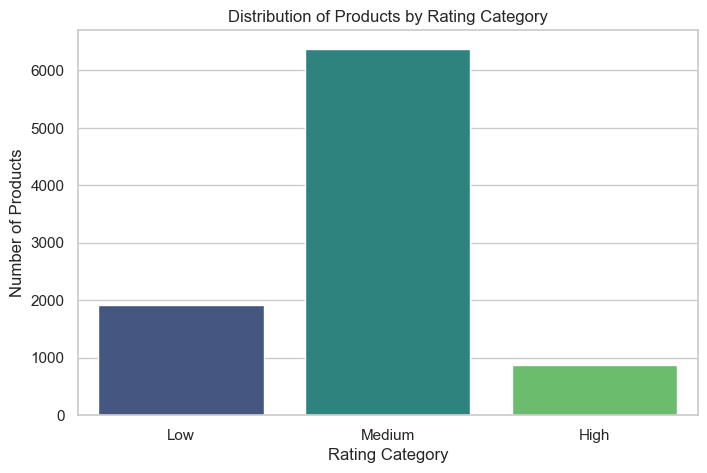

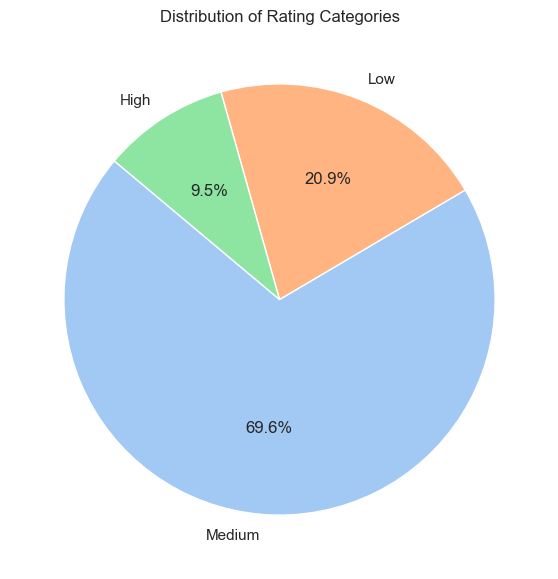

In [65]:
# Cell 8: Rating Category Distribution
plt.figure(figsize=(8,5))
sns.countplot(x='rating_category', data=df, palette='viridis', order=['Low','Medium','High'])
plt.title('Distribution of Products by Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Number of Products')
plt.show()

rating_counts = df['rating_category'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Rating Categories')
plt.show()

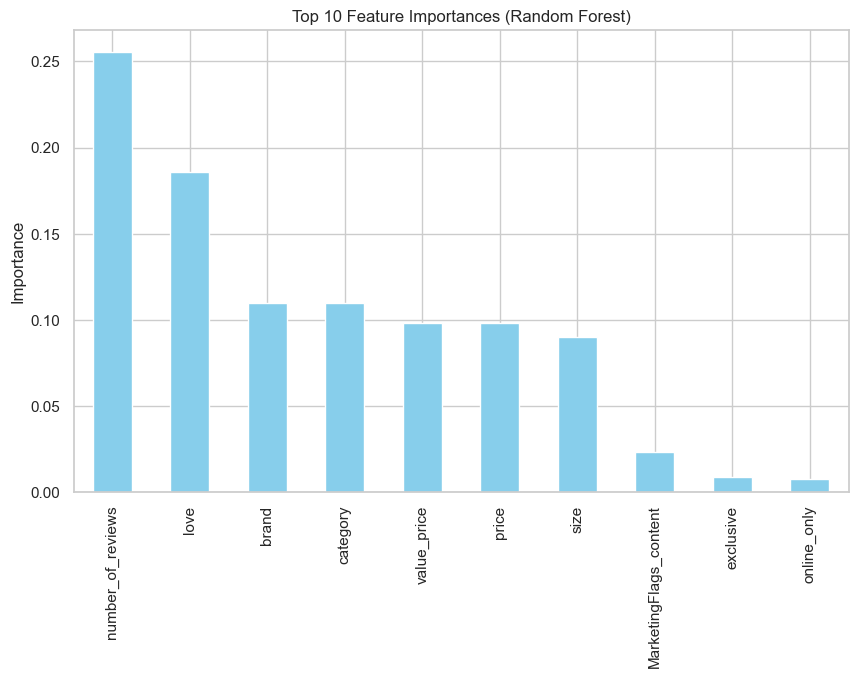

/var/folders/jy/khj1mqxd76g95bsx5f7vlnqm0000gn/T/ipykernel_34830/1344146121.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




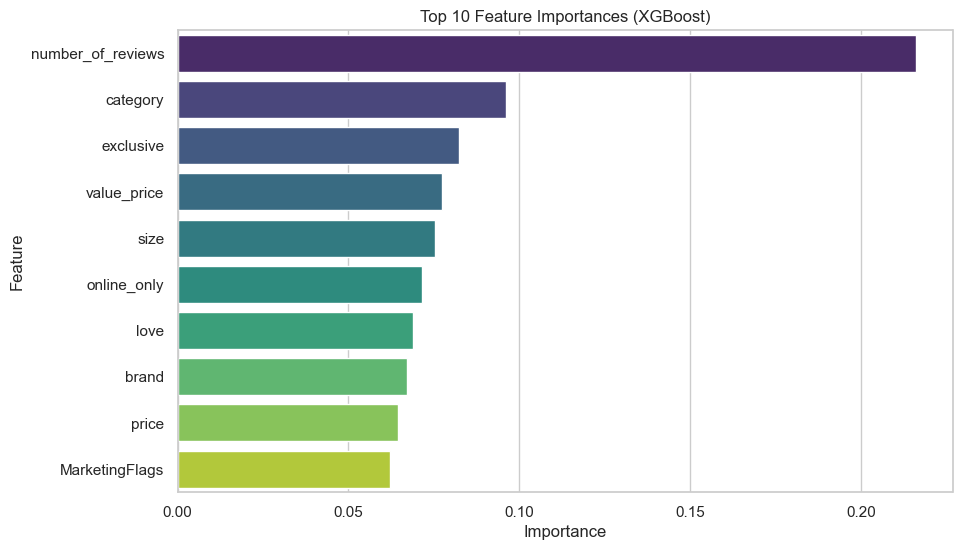

In [66]:
# Cell 9: Feature Importances (Updated for XGBoost 1.7+)

# Random Forest
rf_model = models['Random Forest']
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
rf_importances.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.show()

# XGBoost
xgb_model = models['XGBoost']
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x=xgb_importances.head(10).values,
    y=xgb_importances.head(10).index,
    palette='viridis'
)
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [67]:
# Cell 10: Model Performance Summary

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Initialize empty list to store results
results = []

for name, model in models.items():
    if name == 'Logistic Regression':
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Accuracy': round(acc, 3),
        'Precision': round(prec, 3),
        'Recall': round(rec, 3),
        'F1-Score': round(f1, 3)
    })

# Convert to DataFrame for display
performance_df = pd.DataFrame(results)
performance_df = performance_df.sort_values(by='F1-Score', ascending=False)
display(performance_df)

,Model,Accuracy,Precision,Recall,F1-Score
1,Random Forest,0.728,0.709,0.728,0.714
2,XGBoost,0.710,0.719,0.710,0.714
0,Logistic Regression,0.478,0.656,0.478,0.525


In [68]:
# Create a Series of product names for X_test
# Assuming you did a train_test_split on X and y earlier
X_test_original_names = df.loc[X_test.index, 'name']  # grabs the 'name' column from original df for test rows


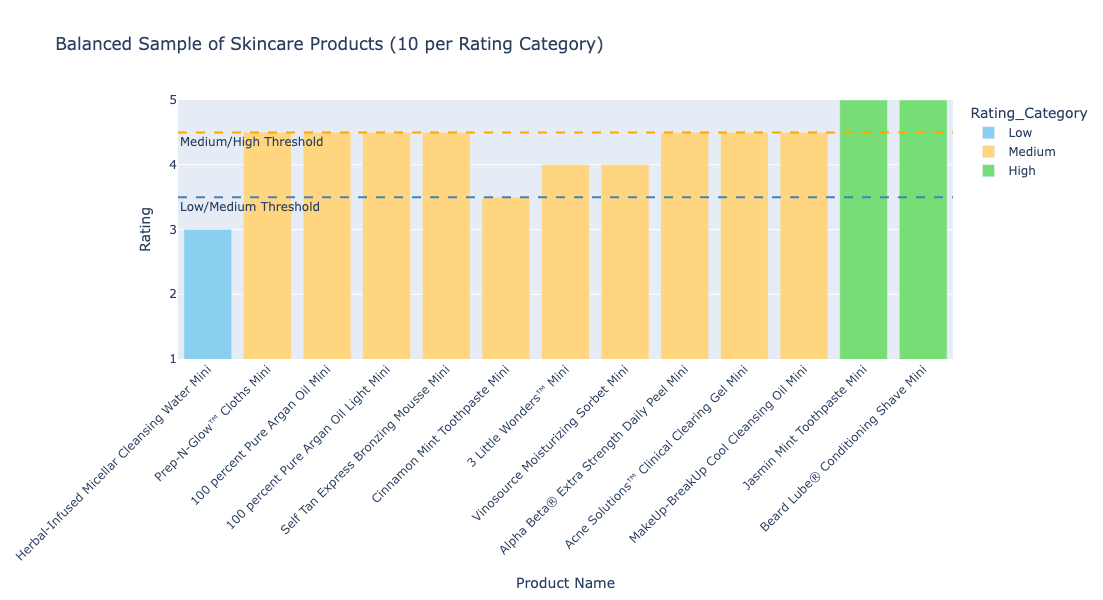

In [69]:
import pandas as pd
import plotly.express as px

# ---------------------------
# Step 1: Filter original dataset to Skincare products
# ---------------------------
category_focus = 'Skincare'
skincare_df = df[df['category'] == category_focus].copy()

# ---------------------------
# Step 2: Define rating categories
# ---------------------------
def rating_to_category(rating):
    if rating < 3.5:
        return 'Low'
    elif rating <= 4.5:
        return 'Medium'
    else:
        return 'High'

skincare_df['Rating_Category'] = skincare_df['rating'].apply(rating_to_category)

# ---------------------------
# Step 3: Sample 10 products from each category (total = 30)
# ---------------------------
n_samples = 10
final_samples = []
for cat in ['Low', 'Medium', 'High']:
    subset = skincare_df[skincare_df['Rating_Category'] == cat]
    if not subset.empty:
        final_samples.append(subset.sample(min(n_samples, len(subset)), random_state=42))

final_sample = pd.concat(final_samples)

# ---------------------------
# Step 4: Interactive bar chart with Plotly
# ---------------------------
color_map = {'Low':'#89CFF0',    # pastel blue
             'Medium':'#FFD580', # pastel orange
             'High':'#77DD77'}   # pastel green

fig = px.bar(
    final_sample,
    x='name',
    y='rating',
    color='Rating_Category',
    color_discrete_map=color_map,
    hover_data={'rating': True, 'name': True, 'Rating_Category': True},
    labels={'name': 'Product Name', 'rating': 'Rating'},
    title='Balanced Sample of Skincare Products (10 per Rating Category)'
)

# Add threshold lines
fig.add_hline(y=3.5, line_dash="dash", line_color="#4682B4", annotation_text="Low/Medium Threshold", annotation_position="bottom left")
fig.add_hline(y=4.5, line_dash="dash", line_color="#FFA500", annotation_text="Medium/High Threshold", annotation_position="bottom left")

fig.update_layout(xaxis_tickangle=-45, yaxis_range=[1,5], width=1000, height=600)
fig.show()

In [70]:
print(skincare_pred_df.columns.tolist())

['brand', 'category', 'size', 'number_of_reviews', 'love', 'price', 'value_price', 'MarketingFlags', 'MarketingFlags_content', 'online_only', 'exclusive', 'limited_edition', 'limited_time_offer', 'Predicted_Rating_Num', 'Rating_Category', 'name']
